[INFO] Project Root: /mnt/disk1/data_jin/Pathway_MAML_final
[INFO] Loading mapping file: /mnt/disk1/data_jin/Pathway_MAML_final/data/Reactome/final/percentile90_min10_matched_combined_pathways.csv
[INFO] Found 12 genes in pathway: 'Serotonin receptors'
[INFO] Loading expression matrix: /mnt/disk1/data_jin/Pathway_MAML_final/data/NCBI/ipf_ssc/second_filtered_combined_counts_transposed.tsv
[INFO] 12 genes are present in the expression matrix.

Analysis Report: Serotonin receptors
Sample Size    : Disease (n=20) vs Control (n=18)
Mean Expression: Disease = 0.1409 | Control = -0.1565
Difference     : 0.2974 (Disease - Control)
P-value        : 2.3468e-02

[INTERPRETATION]
RESULT: The actual expression level in the disease group is significantly HIGHER than in the control group.
   -> Biological Context: Consistent with pathogenic activation or compensatory upregulation.
   -> XAI Interpretation (if model said 'higher_in_label0'):
      The model likely used the 'absence' or 'low basal leve

/tmp/ipykernel_214067/2966401949.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Mean Expression', data=plot_data, palette=['skyblue', 'salmon'])



[INFO] Boxplot saved as 'pathway_expression_analysis.png'.


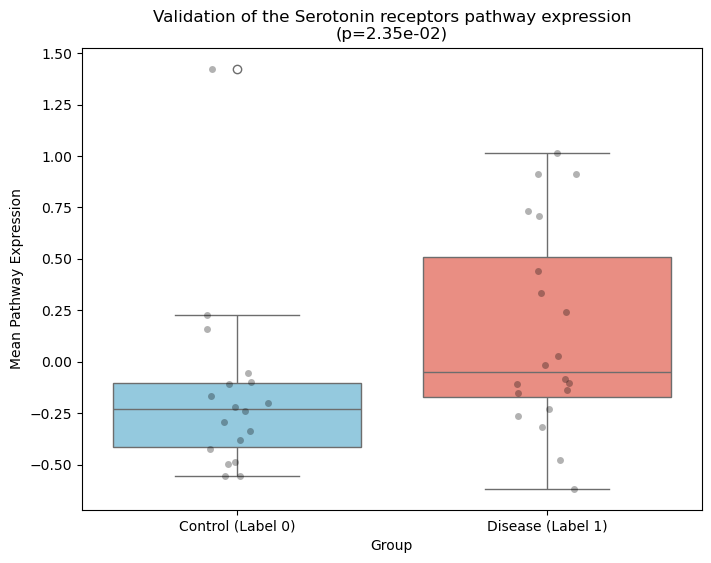

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from pathlib import Path

# 1. Determine Project Root (Jupyter Notebook compatible)
# Start from the directory where this notebook is running
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR

# Move up parent directories until we find the 'data' folder
# This makes the code work regardless of where the notebook is located within the project
while not (PROJECT_ROOT / 'data').exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent: # Reached system root
        print("[WARN] Project root not found. Using current directory as fallback.")
        PROJECT_ROOT = CURRENT_DIR
        break
    PROJECT_ROOT = PROJECT_ROOT.parent

print(f"[INFO] Project Root: {PROJECT_ROOT}")

# 2. Define Directories
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURE_OUTPUT_DIR = RESULTS_DIR / 'figures'

# Create output directory if it does not exist
FIGURE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------
# 1. Configuration & File Paths
# ---------------------------------------------------------
# Path to the pathway-gene mapping file
MAPPING_FILE = DATA_DIR / 'Reactome' / 'final' / 'percentile90_min10_matched_combined_pathways.csv'

# [Config] Select Disease Dataset here
# Options: 'ipf_ssc', 'idiopathic_pulmonary_fibrosis', 'HBV-HCC', etc.
DISEASE_NAME = 'ipf_ssc' 

# Path to the gene expression matrix (transposed, with 'Label' column)
EXPRESSION_FILE = DATA_DIR / 'NCBI' / DISEASE_NAME / 'second_filtered_combined_counts_transposed.tsv'

# The specific pathway name to analyze
TARGET_PATHWAY = "Serotonin receptors"

def analyze_pathway_expression():
    print(f"[INFO] Loading mapping file: {MAPPING_FILE}")
    try:
        df_map = pd.read_csv(MAPPING_FILE)
    except FileNotFoundError:
        print(f"[ERROR] Mapping file not found.")
        return

    # 1. Identify Genes in the Pathway
    # Extract the list of genes (IDs) belonging to the target pathway
    genes_in_pathway = df_map[df_map['Pathway'] == TARGET_PATHWAY]['ID'].unique().tolist()
    print(f"[INFO] Found {len(genes_in_pathway)} genes in pathway: '{TARGET_PATHWAY}'")
    
    if len(genes_in_pathway) == 0:
        print("[ERROR] No genes found. Please check the pathway name spelling.")
        return

    print(f"[INFO] Loading expression matrix: {EXPRESSION_FILE}")
    try:
        df_expr = pd.read_csv(EXPRESSION_FILE, sep='\t')
    except FileNotFoundError:
        print(f"[ERROR] Expression file not found.")
        return
    
    # 2. Filter for Available Genes (Intersection)
    # Only keep genes that exist in both the pathway definition and the expression dataset
    available_genes = [g for g in genes_in_pathway if g in df_expr.columns]
    print(f"[INFO] {len(available_genes)} genes are present in the expression matrix.")
    
    if len(available_genes) == 0:
        print("[ERROR] No matching genes found in the expression file.")
        return

    if 'Label' not in df_expr.columns:
        print("[ERROR] 'Label' column is missing in expression file.")
        return

    # 3. Split Groups (Label 1 = Disease, Label 0 = Control)
    group_disease = df_expr[df_expr['Label'] == 1][available_genes]
    group_control = df_expr[df_expr['Label'] == 0][available_genes]
    
    n_disease = len(group_disease)
    n_control = len(group_control)
    
    # 4. Calculate Representative Expression Score (Mean of genes per sample)
    scores_disease = group_disease.mean(axis=1)
    scores_control = group_control.mean(axis=1)
    
    mean_d = scores_disease.mean()
    mean_c = scores_control.mean()
    
    # 5. Statistical Test (Two-sided Mann-Whitney U)
    # Tests if the distributions of the two groups are significantly different
    u_stat, p_val = mannwhitneyu(scores_disease, scores_control, alternative='two-sided')
    
    # 6. Result Interpretation
    print("\n" + "=" * 80)
    print(f"Analysis Report: {TARGET_PATHWAY}")
    print(f"Sample Size    : Disease (n={n_disease}) vs Control (n={n_control})")
    print(f"Mean Expression: Disease = {mean_d:.4f} | Control = {mean_c:.4f}")
    print(f"Difference     : {mean_d - mean_c:.4f} (Disease - Control)")
    print(f"P-value        : {p_val:.4e}")
    print("=" * 80)
    
    print("\n[INTERPRETATION]")
    if p_val < 0.05:
        if mean_d > mean_c:
            # Case: Disease > Control
            print("RESULT: The actual expression level in the disease group is significantly HIGHER than in the control group.")
            print("   -> Biological Context: Consistent with pathogenic activation or compensatory upregulation.")
            print("   -> XAI Interpretation (if model said 'higher_in_label0'):")
            print("      The model likely used the 'absence' or 'low basal level' of this pathway in healthy samples")
            print("      as a key predictor for the Control class (Clean Room Hypothesis).")
        else:
            # Case: Disease < Control
            print("RESULT: The actual expression level in the disease group is significantly LOWER than in the control group.")
            print("   -> Biological Context: Consistent with loss of function or deficiency in disease.")
            print("   -> XAI Interpretation (if model said 'higher_in_label1'):")
            print("      The model likely utilized this 'deficiency' (low values) as a strong negative feature")
            print("      to predict the Disease class (Deficiency as Evidence).")
    else:
        # Case: No significant difference
        print("RESULT: No significant difference in mean expression between groups.")
        print("   -> The model may be detecting complex non-linear interactions or variance differences")
        print("      rather than simple up/down regulation.")

    # 7. Visualization
    plt.figure(figsize=(8, 6))
    plot_data = pd.DataFrame({
        'Mean Expression': np.concatenate([scores_control, scores_disease]),
        'Group': ['Control (Label 0)'] * len(scores_control) + ['Disease (Label 1)'] * len(scores_disease)
    })
    
    sns.boxplot(x='Group', y='Mean Expression', data=plot_data, palette=['skyblue', 'salmon'])
    sns.stripplot(x='Group', y='Mean Expression', data=plot_data, color='black', alpha=0.3, jitter=True)
    
    plt.title(f"Validation of the {TARGET_PATHWAY} pathway expression\n(p={p_val:.2e})")
    plt.ylabel("Mean Pathway Expression")
    
    save_filename = "pathway_expression_analysis.png"
    plt.savefig(save_filename)
    print(f"\n[INFO] Boxplot saved as '{save_filename}'.")

if __name__ == "__main__":
    analyze_pathway_expression()